<a id='top'></a>

[1. SQL](#sql)<br>
[2. EDA](#eda)<br>
[3. Modeling](#modeling)<br>
[4. Production](#prod)<br>
[5. Evaluation](#eval)<br>

In [ ]:
# References
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# https://www.kaggle.com/amavuduru/exploratory-data-analysis-and-logistic-regression

In [177]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pycaret import classification
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from pycaret.classification import *
%matplotlib inline
import pyodbc
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=OpenBook;'
                      'Trusted_Connection=yes;')

<a id='sql'></a>
# SQL Query
[Top](#top)<br>

In [178]:
# For training model, declare 4 prior terms. For production model, declare current term only and leave others blank
data_current = pd.read_sql_query("""\
declare @term1 varchar(50) = '2022fa'
declare @term2 varchar(50) = ''
declare @term3 varchar(50) = ''
declare @term4 varchar(50) = ''

select
	t1.[student id]
	, t1.Term [Start Term]
	, [GPA Institutional Cumulative]
	, case when t2.[Student ID] is not null then 1 else 0 end [Retained]
	, case when ([start of term retention status] in ('new', 'transfer in') or [starting cohort term] = t1.term) then 1 else 0 end [new_student]
	, case when tests.[Student ID] is null then 0 else 1 end [ptest_exists]
	, max(aleks) aleks, max(sat_english) sat_english, max(sat_math) sat_math, max(act_composite) act_composite, max(cccrtw) cccrtw
	, case when max(count_tests) is null then 0 else max(count_tests) end count_tests
	, case when waiver.[Student ID] is null then 0 else 1 end test_waiver 
    , t1.[Home College] [Home_College]
	, case when t1.[Home College] = 'DA' then 1 else 0 end [HC_DA]
	, case when t1.[Home College] = 'KK' then 1 else 0 end [HC_KK]
	, case when t1.[Home College] = 'MX' then 1 else 0 end [HC_MX]
	, case when t1.[Home College] = 'OH' then 1 else 0 end [HC_OH]
	, case when t1.[Home College] = 'TR' then 1 else 0 end [HC_TR]
	, case when t1.[Home College] = 'WR' then 1 else 0 end [HC_WR]
	, case when t1.[Home College] not in ('DA', 'HW', 'KK', 'MX', 'OH', 'TR', 'WR') then 1 else 0 end [HC_other]
	, [First_reg]
	, case when t1.[Gender] = 'Male' then 1 else 0 end [Gender_Male]
	, case when t1.[Gender] = '(Blank)' then 1 else 0  end [Gender_Unknown]
	, case when [Age at Census] is null then 0 else [age at census] end [age]
	, case when t1.[Ethnicity] = 'Black' then 1 else 0 end [Eth_Black]
	, case when t1.[Ethnicity] = 'Asian' then 1 else 0 end [Eth_Asian]
	, case when t1.[Ethnicity] = 'White' then 1 else 0 end [Eth_White]
	, case when t1.[Ethnicity] not in ('Black', 'Hispanic', 'White', 'Asian') then 1 else 0 end [Eth_Other]
	, case when t1.[STAR Eligibility] = 'STR' then 1 else 0 end [Star Status]
	, case when [Declared Degree] in ('AC', 'BC') then 1 else 0 end [Deg_cert]
	, case when [Declared Degree] in ('AAS', 'AGS') then 1 else 0 end [Deg_terminal]
	, case when [Full Or Part Time] = 'Full-Time' then 1 else 0 end [FT]
	, case when [Ever Early College] is null then 0 else 1 end [Ever Early College]
	, case when t1.[Athletic Indicator] = 'no' then 0 else 1 end [Athletic Indicator]
	, case when pelig.[Student ID] is null then 0 else 1 end [Pell Eligibility Status]
--	, case when pell_recipient_status = 'Pell Recipient' then 1 else 0 end [pell recipient status]

from
	openbook.dbo.pvt_studentterms t1
	
left join /*Exclude completers*/
(select distinct [Student ID], [Term Order]
from openbook.dbo.pvt_studentdegrees) 
degree on t1.[Student ID] = degree.[Student ID] and t1.[Term Order] = degree.[Term Order]

left join /*Check subsequent term enrollment*/
(select [Student ID], [Term Order], term
from openbook.dbo.pvt_StudentTerms
where Enrolled = 'yes' and [Instructional Area] = 'Semester Credit')
t2 on t1.[Student ID] = t2.[Student ID] and t1.[Term Order] = (t2.[Term Order] - 1)

/*Registration Date*/
left join
(select colleagueid, term, min([first_reg]) [First_reg] from (
	(select colleagueid, term, datediff(day, startDate, statusdate) [First_reg] from openbook.dbo.tbl_dropadd da
		left join (select  classsection, startdate from openbook.dbo.tbl_classsections) sd on da.classSection = sd.classSection
	where [status] = 'E' and academicLevel = 'cred' group by [colleagueId], term, startdate, statusdate)) reg2
group by colleagueid, term)
reg on t1.[student id] = reg.colleagueid and t1.term = reg.term

/*Early College*/
left join
(select distinct [student id], [Ever Early College] = 'Was EC' from openbook.dbo.pvt_studentterms where [enrolled] = 'yes' and [Early College] = 'yes') 
ec on t1.[Student ID] = ec.[Student id]

/*Placement test scores and count of tests*/
left join
(select [student id], [SAT - New - Evidence Based Read & Writing] sat_english, [SAT - New - Math Section Score SAT] sat_math, [CCCRTW - Writing] cccrtw
	, [ACT - Composite] act_composite, [ALEKS PPL - Math] aleks, count_tests, [term taken order]
from  
	(select [student id], test, [high score], [term taken order], row_number() over (partition by [student id] order by [term taken order]) count_tests
	from openbook.dbo.pvt_studenttests
	where [test] in ('CCCRTW - Writing', 'ACT - Composite', 'ALEKS PPL - Math') or ([test category] in ('sat') and [high score] >=100))
	sourcetable
	PIVOT
	(max([high score])
	for test IN ([SAT - New - Evidence Based Read & Writing], [SAT - New - Math Section Score SAT], [CCCRTW - Writing], [ACT - Composite], [ALEKS PPL - Math])) pivottable) 
tests on t1.[student id] = tests.[Student ID] and t1.[Term Order] >= tests.[term taken order]

/*Placement test waiver*/
left join
(select [student id], min([term taken order]) [term taken order] from openbook.dbo.pvt_studenttests 
where [test category] = 'placement test waiver' group by [student id])-- and concat(left(@term1, 4), 02) >= [term taken order])
waiver on t1.[student id] = waiver.[Student ID] and t1.[term order] >= waiver.[term taken order]

/*Student Financials: Pell eligible, Pell recipient, checklist items, DEL holds*/
left join
(select distinct [Student ID], [Financial Aid Federal ID], [Financial Aid Year]
from [Openbook].[dbo].[pvt_StudentFinancialAids] 
where  [Financial Aid Federal ID] = 'PELL' and [financial aid pell candidacy] = 'yes') 
pelig on t1.[Student ID] = pelig.[student id] and left(t1.Term, 4) = pelig.[financial aid year] - 1

where
	t1.Term in (@term1, @term2, @term3, @term4)
	and Enrolled = 'yes' and [Instructional Area] = 'semester credit' 
	and degree.[Student ID] is null and [Early College] = 'no' and [declared degree] not in ('na')
group by t1.[student id], t2.[Student ID], [start of term retention status], tests.[Student ID], waiver.[Student ID], t1.Term, t1.[Home College]
	, [First_reg], t1.[Gender], [age at census], t1.Ethnicity, t1.[STAR Eligibility], [Declared Degree], [Full or Part Time], [Ever Early College]
	, t1.[Athletic Indicator], pelig.[Student ID], [Starting Cohort Term], [GPA Institutional Cumulative]
order by [student id], [Start Term]

""", conn)

data_current = pd.DataFrame(data_current)
data_current.shape

(19154, 36)

<AxesSubplot:xlabel='max_placement_score', ylabel='GPA Institutional Cumulative'>

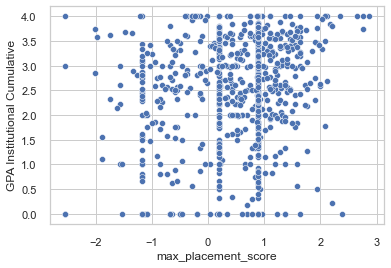

In [179]:
# Feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data_current[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data_current, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

# For training data - wanted to see relationship between placement test score (scaled) and term GPA
sampledf = data_scaled.sample(n=1000)
sns.scatterplot(x = sampledf['max_placement_score'], y = sampledf['GPA Institutional Cumulative'])

<a id='eda'></a>

# EDA
[Top](#top)<br>

In [ ]:
# Variables to test include:

# new or continuing student
# placement tests
# waived out of placement test
# home college (DA, KK, MX, OH, TR, WR, other, ref = HW)
# first reg date
# gender (male, other, ref = female)
# age
# ethnicity (black, asian, white, other, ref = hispanic)
# star status (free tuition)
# degree (certificate, terminal, coursetaker, ref=transfer)
# full time status
# ever early college
# athletic indicator
# pell eligibility status

In [5]:
data_current.describe()

,GPA Institutional Cumulative,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,test_waiver,HC_DA,HC_KK,HC_MX,HC_OH,HC_TR,HC_WR,HC_other,First_reg,Gender_Male,Gender_Unknown,age,Eth_Black,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status
count,83466.000000,86875.000000,86875.000000,86875.000000,57687.000000,12205.000000,12111.000000,11506.000000,46998.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.0,86875.00000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000,86875.000000
mean,2.678129,0.698774,0.309272,0.793347,41.788583,498.951249,490.672942,18.442986,4.536216,2.050486,0.072921,0.107442,0.055482,0.224219,0.047735,0.103206,0.223781,0.0,-48.58415,0.397088,0.001669,24.153094,0.284017,0.058129,0.119505,0.030319,0.151620,0.025071,0.356017,0.501755,0.107545,0.010601,0.509836
std,0.946114,0.458793,0.462196,0.404907,22.584887,82.990532,87.724145,3.885554,1.507152,1.610831,0.260008,0.309676,0.228920,0.417069,0.213207,0.304229,0.416780,0.0,43.41343,0.489297,0.040820,8.090915,0.450948,0.233990,0.324384,0.171466,0.358654,0.156340,0.478823,0.500000,0.309807,0.102417,0.499906
min,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-229.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.200000,0.000000,0.000000,1.000000,25.000000,440.000000,430.000000,16.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-70.00000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.820000,1.000000,0.000000,1.000000,39.000000,500.000000,490.000000,18.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-33.00000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.360000,1.000000,1.000000,1.000000,59.000000,560.000000,550.000000,21.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-15.00000,1.000000,0.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,4.000000,1.000000,1.000000,1.000000,100.000000,790.000000,800.000000,35.000000,6.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,22.00000,1.000000,1.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# see which variables might show large variation between retained/not retained
data_current.groupby('Retained').mean().to_clipboard()

<AxesSubplot:>

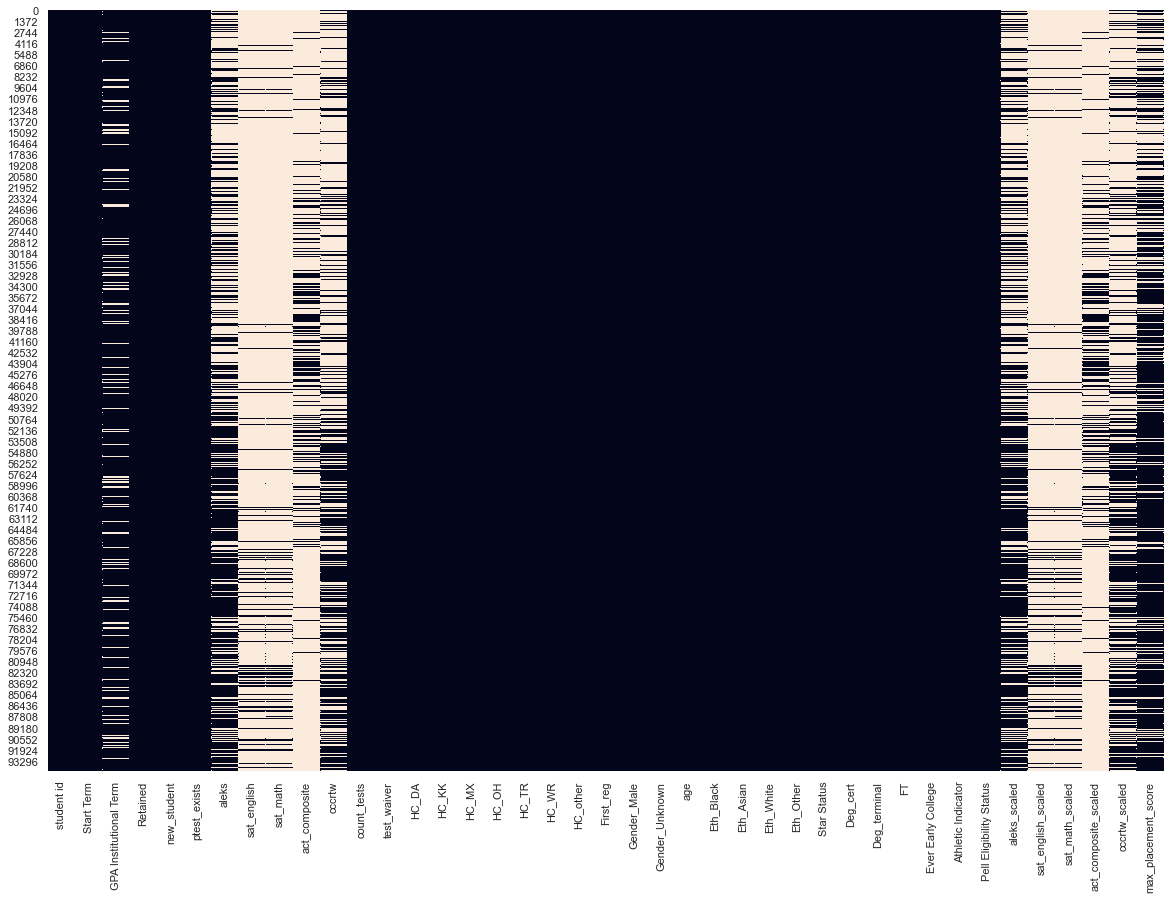

In [11]:
# check for null values
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.isnull(), cbar = False)

<AxesSubplot:xlabel='Retained', ylabel='count'>

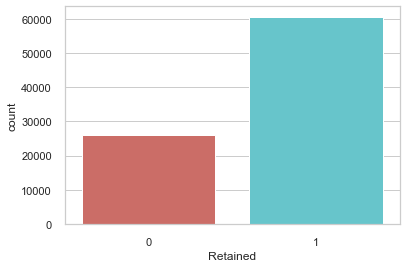

In [6]:
# Visualize retained/not retained 
sns.countplot(x='Retained',data=data_current, palette='hls')

<AxesSubplot:xlabel='count_tests', ylabel='Count'>

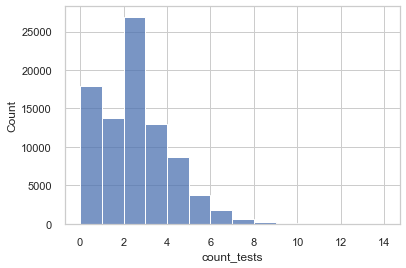

In [7]:
# view distribution for different numeric variables
sns.histplot(data = data_current, x='count_tests', binwidth = 1)

<AxesSubplot:xlabel='ptest_exists', ylabel='count'>

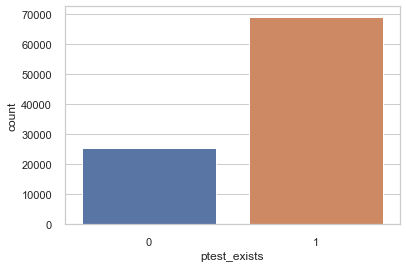

In [6]:
# view counts for categorical variables
sns.countplot(x = 'ptest_exists', data = data_current)

<AxesSubplot:>

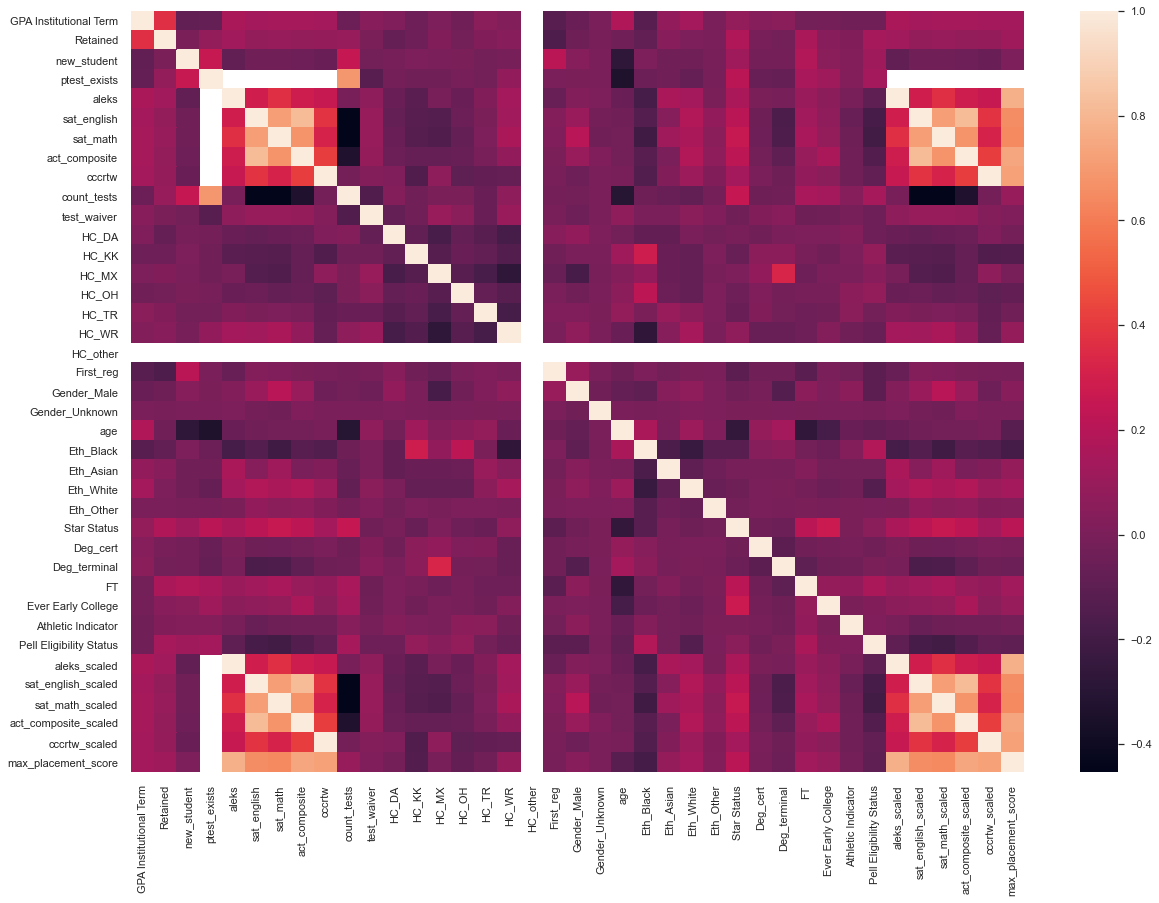

In [9]:
# Visualize correlations between data
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.corr())

<AxesSubplot:xlabel='max_placement_score', ylabel='GPA Institutional Term'>

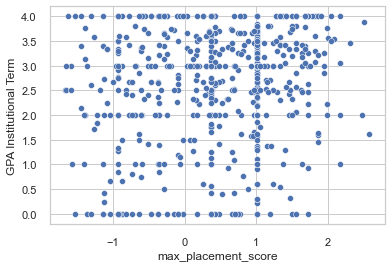

In [8]:
# Feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data_current[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data_current, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

# For training data - wanted to see relationship between placement test score (scaled) and term GPA
sampledf = data_scaled.sample(n=1000)
sns.scatterplot(x = sampledf['max_placement_score'], y = sampledf['GPA Institutional Term'])

<a id='modeling'></a>

# Modeling
[Top](#top)<br>

In [107]:
# Notes on pycaret classification modeling:
# data split into train/test set
# numeric/categorical features inferred (should have been correctly set up by SQL query)
# 10 fold cross validation used
# numeric imputation done using mean value, categorical done using mode
# 70/30 imbalanced data set corrected via SMOTE

from pycaret.classification import *
classification_setup = classification.setup(data= data_scaled, fix_imbalance = True, target='Retained',
                                            ignore_features = ['student id', 'Start Term',
                                                           'aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw',
                                                           'aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 
                                                            'act_composite_scaled', 'cccrtw_scaled'])

,Description,Value
0,session_id,8484
1,Target,Retained
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(86875, 42)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,25
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# tests different sklearn classification models to determine high performers
classification.compare_models(include = ['lightgbm', 'xgboost', 'gbc', 'rf', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7673,0.7897,0.8978,0.7953,0.8435,0.3963,0.4076,2.3670
catboost,CatBoost Classifier,0.7671,0.7891,0.9015,0.7933,0.8439,0.3927,0.4054,18.4040
xgboost,Extreme Gradient Boosting,0.7656,0.7859,0.8990,0.7930,0.8427,0.3898,0.4019,7.0460
gbc,Gradient Boosting Classifier,0.7543,0.7789,0.8568,0.8043,0.8297,0.3907,0.3933,5.7970
rf,Random Forest Classifier,0.7492,0.7670,0.8750,0.7890,0.8298,0.3587,0.3658,4.7320


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7948, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [108]:
# use highest performer
created_model = create_model('lightgbm', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7682,0.7913,0.8993,0.7958,0.8444,0.3971,0.4087
1,0.7599,0.7805,0.8902,0.7922,0.8383,0.3785,0.3884
2,0.7729,0.7985,0.9062,0.7969,0.8480,0.4063,0.4197
3,0.7706,0.7940,0.8969,0.7995,0.8454,0.4069,0.4171
4,0.7704,0.7940,0.8947,0.8004,0.8450,0.4081,0.4177
Mean,0.7684,0.7917,0.8975,0.7969,0.8442,0.3994,0.4103
Std,0.0045,0.0060,0.0053,0.0029,0.0032,0.0111,0.0116


In [109]:
tuned_model = tune_model(created_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7705,0.7877,0.8991,0.7981,0.8456,0.4046,0.4157
1,0.7670,0.7946,0.9026,0.7928,0.8442,0.3903,0.4035
2,0.7556,0.7730,0.8890,0.7885,0.8357,0.3654,0.3756
3,0.7667,0.7872,0.8977,0.7950,0.8433,0.3933,0.4046
4,0.7701,0.8008,0.9024,0.7961,0.8459,0.4004,0.4128
5,0.7714,0.7917,0.9038,0.7966,0.8468,0.4034,0.4161
6,0.7717,0.7949,0.9014,0.7982,0.8467,0.4067,0.4185
7,0.7686,0.7950,0.8998,0.7959,0.8447,0.3981,0.4098
8,0.7703,0.7959,0.8958,0.7997,0.8450,0.4068,0.4168


In [53]:
# # df_test = pd.concat([get_config("X_test"), get_config("y_test")], axis = 1)
# df_test = data_current.loc[get_config('X_test').index]

# # feature engineering placement tests to get normalized highest placement test score
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_X = sc_X.fit_transform(df_test[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
# sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
#                                         , 'cccrtw_scaled'])
# data_scaled = pd.concat([df_test.reset_index(), sc_X], axis = 1)
# data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
#                                         , 'cccrtw_scaled']].max(axis=1)                           

,index,student id,Start Term,GPA Institutional Cumulative,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,...,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
0,82057,002497583,2020FA,3.75,1,1,1,66.0,NaN,NaN,...,1,0,0,0,1.068418,NaN,NaN,NaN,NaN,1.068418
1,10452,000963128,2021FA,2.55,1,0,0,NaN,NaN,NaN,...,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,44662,002283475,2020FA,3.50,0,0,1,30.0,NaN,NaN,...,1,0,0,1,-0.529129,NaN,NaN,NaN,-2.358431,-0.529129
3,15608,001124987,2020FA,0.75,0,0,1,84.0,NaN,NaN,...,1,0,0,0,1.867191,NaN,NaN,NaN,NaN,1.867191
4,73316,002413843,2020FA,3.25,1,0,1,20.0,NaN,NaN,...,1,0,0,1,-0.972891,NaN,NaN,NaN,-1.028325,-0.972891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26058,25165,002086492,2019FA,2.52,1,0,1,52.0,NaN,NaN,...,0,0,0,1,0.447150,NaN,NaN,NaN,NaN,0.447150
26059,27825,002154822,2018FA,2.21,1,0,1,36.0,NaN,NaN,...,0,1,0,0,-0.262871,NaN,NaN,0.433901,0.301781,0.433901
26060,68489,002371734,2021FA,2.42,1,0,1,60.0,NaN,NaN,...,0,1,0,0,0.802160,NaN,NaN,NaN,0.301781,0.802160
26061,56189,002324090,2021FA,3.69,1,0,1,32.0,NaN,NaN,...,1,0,0,0,-0.440376,NaN,NaN,NaN,-1.028325,-0.440376


In [66]:
# current_set = predict_model(tuned_model, raw_score = True, data = data_scaled)
# #current_set = pd.concat([current_set, get_config('y_test').reset_index(drop = True)], axis = 1)
# current_set.to_clipboard()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7629,0.7843,0.8853,0.7980,0.8393,0.3918,0.3996


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

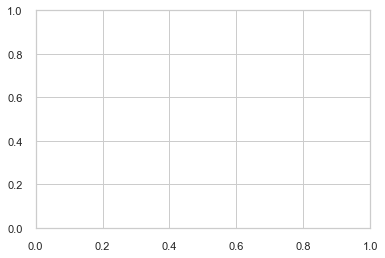

In [110]:
# review model metrics
evaluate_model(tuned_model)

In [14]:
# create final model to be used on current term data
final_model = finalize_model(tuned_model)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=200, n_jobs=-1, num_leaves=20, objective=None,
               random_state=2059, reg_alpha=0.15, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LGBMClassifier(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=-1,
       

In [15]:
save_model(final_model, 'fa22_retention_model_20220725')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=LGBMClassifier(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=200, n_jobs=-1, num_leaves=20, objective=None,
               random_state=2059, reg_alpha=0.15, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), model_name=fa22_retention_model_20220725, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['student id',
                                                       'Start Term', 'aleks',
            

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['student id',
                                                        'Start Term', 'aleks',
                                                        'sat_english',
                                                        'sat_math',
                                                        'act_composite',
                                                        'cccrtw', 'aleks_scaled',
                                                        'sat_english_scaled',
                                                        'sat_math_scaled',
                                                        'act_composite_scaled',
                                                        'cccrtw_scaled'],
                                       id_columns=[],
                      

<a id='prod'></a>

# Production model for current term
[Top](#top)<br>

#### BEFORE RUNNING CODE BELOW - edit original SQL query to be current term only
[SQL Query](#sql)<br>

In [69]:
final_model = load_model('fa22_retention_model_20220725')

Transformation Pipeline and Model Successfully Loaded


In [103]:
# feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data_current[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data_current, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

In [3]:
# run model on current data, and set tiers based on college percentages served by tier
current_set = predict_model(final_model, raw_score = True, data = data_scaled)
current_set['hc_percentile'] = current_set.groupby(['Home_College'])['Score_1'].rank(pct=True)
def tiers(df):
    if (df['Home_College'] == 'DA' and df['hc_percentile'] < .22)\
    or (df['Home_College'] == 'HW' and df['hc_percentile'] < .16)\
    or (df['Home_College'] == 'KK' and df['hc_percentile'] < .16)\
    or (df['Home_College'] == 'MX' and df['hc_percentile'] < .05)\
    or (df['Home_College'] == 'OH' and df['hc_percentile'] < .16)\
    or (df['Home_College'] == 'TR' and df['hc_percentile'] < .14)\
    or (df['Home_College'] == 'WR' and df['hc_percentile'] < .09):
        return 'Tier 1'
    elif (df['Home_College'] == 'DA' and df['hc_percentile'] < .55)\
    or (df['Home_College'] == 'HW' and df['hc_percentile'] < .54)\
    or (df['Home_College'] == 'KK' and df['hc_percentile'] < .54)\
    or (df['Home_College'] == 'MX' and df['hc_percentile'] < .29)\
    or (df['Home_College'] == 'OH' and df['hc_percentile'] < .54)\
    or (df['Home_College'] == 'TR' and df['hc_percentile'] < .87)\
    or (df['Home_College'] == 'WR' and df['hc_percentile'] < .32):
        return 'Tier 2'
    else:
        return 'Tier 3'
current_set['tier'] = current_set.apply(tiers, axis = 1)
current_set.head()

NameError: name 'final_model' is not defined

<AxesSubplot:xlabel='Score_1', ylabel='Count'>

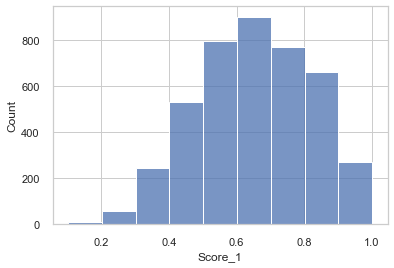

In [67]:
# visualize current term distribution of scores
sns.histplot(data = current_set[current_set['Home_College'] == 'HW'], x='Score_1', binwidth = .1)

<AxesSubplot:xlabel='tier', ylabel='count'>

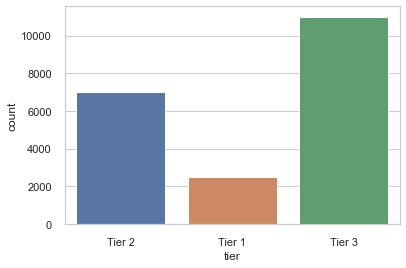

In [94]:
# visualize current term distribution of scores
sns.countplot(data = current_set, x='tier')

In [98]:
# insert into SQL to update report for Tableau dashboard and end users
import pyodbc
conn_ds = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=DecisionSupport;'
                      'Trusted_Connection=yes;')
cursor = conn_ds.cursor()
# delete old data
cursor.execute("drop table decisionsupport.dbo.[retention scores 2021FA]")
conn_ds.commit()
cursor.close()

In [99]:
# insert Dataframe into SQL Server:
cursor = conn_ds.cursor()
cursor.execute("""create table decisionsupport.dbo.[retention scores 2021FA] 
               ([Student_ID] varchar(100), [Retention_Score] varchar(100), tier varchar(100))""")
conn_ds.commit()
cursor.close()

In [100]:
cursor = conn_ds.cursor()
for index, row in current_set[['student id', 'Score_1', 'tier']].iterrows():
    cursor.execute("""\
    insert into decisionsupport.dbo.[retention scores 2021FA] ([Student_ID], [Retention_Score], [tier]) values(?, ?, ?)"""
                   , row[0], row.Score_1 * 100, row[2])
conn_ds.commit()
cursor.close()

<a id='eval'></a>

# Evaluation of Training results vs Production
[Top](#top)<br>

- Evaluation metrics for testing data vs. actual outcome
- Calibration curve of test v actual
- Brier score of test v actual

In [99]:
### Evaluation Metrics: Accuracy, AUC, Precision/Recall, confusion matrix
# Test set
current_set = predict_model(final_model, raw_score = True, data = data_scaled)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7753,0.8061,0.9076,0.7984,0.8495,0.4132,0.4267


In [180]:
### Evaluation Metrics: Accuracy, AUC, Precision/Recall, confusion matrix
# 2022FA
current_set = predict_model(final_model, raw_score = True, data = data_scaled)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['student id',
                                                       'Start Term', 'aleks',
                                                       'sat_english',
                                                       'sat_math',
                                                       'act_composite',
                                                       'cccrtw', 'aleks_scaled',
                                                       'sat_english_scaled',
                                                       'sat_math_scaled',
                                                       'act_composite_scaled',
                                                       'cccrtw_scaled'],
                 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7174,0.7516,0.8727,0.7417,0.8019,0.3205,0.3337


### Confusion Matrix for training set vs. current data
#### Training set
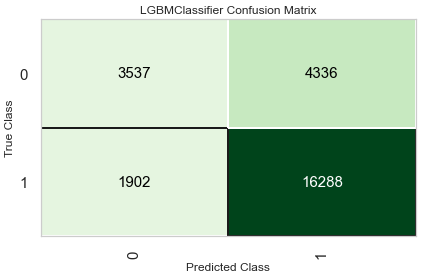
#### 2022FA


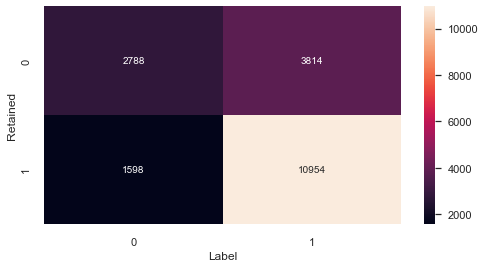

In [181]:
plt.figure(figsize=(8, 4))
sns.heatmap(pd.crosstab(current_set['Retained'], current_set['Label']), annot = True, fmt ='0')
plt.show()

### Calibration Curve
#### Training set
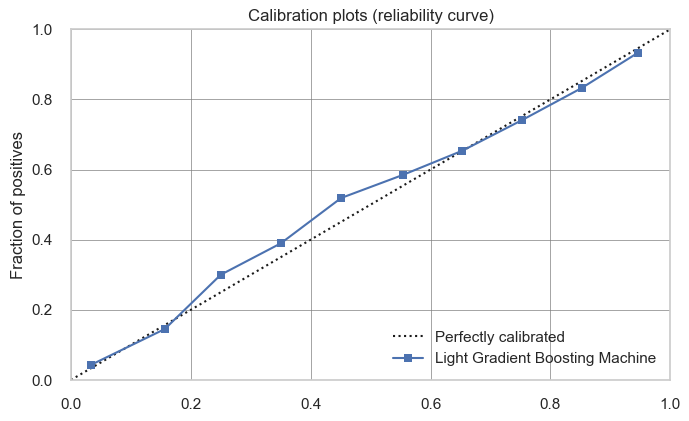
#### 2022FA

In [182]:
# First, sort the dataframe by the 'Score' column
current_set.sort_values(by='Score_1', inplace=True)

# Create bins of equal size
bins = np.linspace(min(current_set['Score_1']), max(current_set['Score_1']), 10)

# Create a new column for the binned scores
current_set['Score_Binned'] = pd.cut(current_set['Score_1'], bins)

# Calculate the average score for each bin
bin_avg = current_set.groupby('Score_Binned').mean()['Retained']
bin_avg_predicted = current_set.groupby('Score_Binned').mean()['Score_1']
print(bin_avg)
print(bin_avg_predicted)

Score_Binned
(0.0079, 0.117]    0.119760
(0.117, 0.225]     0.246358
(0.225, 0.334]     0.341693
(0.334, 0.443]     0.420094
(0.443, 0.551]     0.493234
(0.551, 0.66]      0.576658
(0.66, 0.769]      0.674072
(0.769, 0.877]     0.786472
(0.877, 0.986]     0.907972
Name: Retained, dtype: float64
Score_Binned
(0.0079, 0.117]    0.072696
(0.117, 0.225]     0.182331
(0.225, 0.334]     0.281571
(0.334, 0.443]     0.386873
(0.443, 0.551]     0.499979
(0.551, 0.66]      0.609407
(0.66, 0.769]      0.717723
(0.769, 0.877]     0.823427
(0.877, 0.986]     0.924161
Name: Score_1, dtype: float64


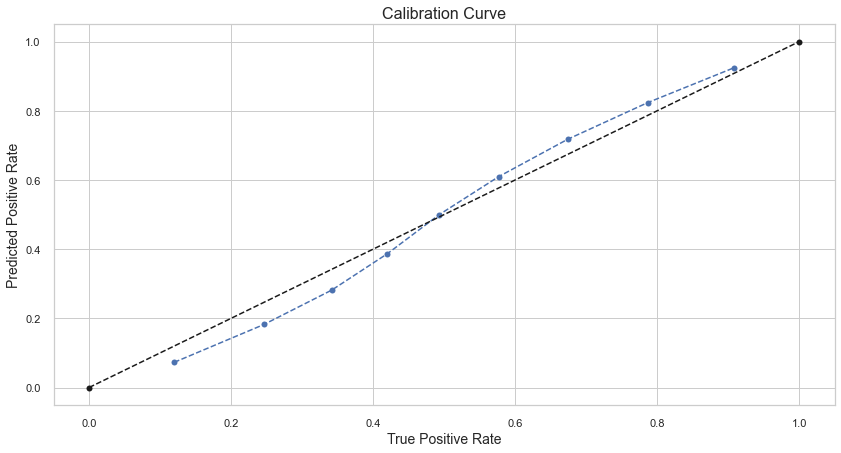

In [183]:
plt.figure(figsize=(14,7))

# Plot calibration curve
plt.plot(bin_avg, bin_avg_predicted, marker='o', linestyle='--', color='b')

# Plot reference line
plt.plot([0, 1], [0, 1], marker='o', linestyle='--', color='k')

# Add labels
plt.xlabel('True Positive Rate', fontsize=14)
plt.ylabel('Predicted Positive Rate', fontsize=14)

# Add title
plt.title('Calibration Curve', fontsize=16)

# Add legend
plt.legend(loc="lower right", fontsize=14)

plt.show()

In [141]:
current_set.to_clipboard()